# Notebook 2 - Design of inhibitors against histamine H1 receptor

By Vincent Blay, June 2021

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVR

%run "./code/macaw_class.py"
%run "./code/macaw_plotting.py"

## 1. Binding to histamine H1 receptor

### 1.1 Data preparation

This spreadsheet contains conventional descriptors precomputed. In this notebook, we will only be using the columns `rdkit_smiles` and `activity`.

In [3]:
df = pd.read_csv('./data/data_H1.csv')
df.head()

,compound_id,rdkit_smiles,activity
0,CHEMBL3925977,O=C(O)c1ccc2cccnc2c1N1CCN(CCc2ccc(OCCCN3CCCCCC...,5.599999
1,CHEMBL2171045,O=C(NS(=O)(=O)c1cccc(C(F)(F)F)c1)N1CCC(N2CCC(O...,7.400008
2,CHEMBL3753784,COc1ccc(CNc2nc(N3CCN(C)CC3)nc3c2CCc2ccccc2-3)c...,5.200000
3,CHEMBL3917794,O=C(O)c1ccc2cccc(N3CCN(CCc4ccc(OCCCN5CCCCCC5)c...,6.599998
4,CHEMBL240394,O=C(c1cc(F)cc(F)c1)N1CCN(c2ccc(OCCCN3CCCCC3)cc...,5.700001


In [4]:
Y = df.activity.to_numpy() # Y are pKi values
smiles = df.rdkit_smiles

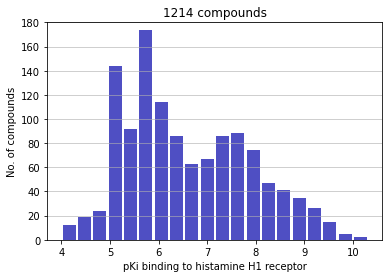

In [5]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [6]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size = 0.2, random_state = 42)

### 1.2 Compute Macaw embeddings

In [7]:
#mcw = Macaw_optimus(smi_train, y_train, fast=False, verbose=True, Y=y_train)
mcw = Macaw(smi_train, edim = 15, Nlndmk = 50, Y = y_train, fptype = "atompairs", metric = "sokal")

In [8]:
X_train = mcw.transform()
X_train.shape

(971, 15)

In [9]:
X_test = mcw.transform(smi_test)
X_test.shape

(243, 15)

### 1.3 Modeling using a SVR

In [10]:
for C in [1,3,5,7,10,30,50]:
    regr = SVR(kernel = "rbf", C=C, epsilon = .3)
 
    scores = cross_val_score(regr, X_train, y_train, cv = 5)
    print(scores.mean())

0.6785714499200483
0.6950902496066351
0.7015683091565985
0.7046649069801556
0.7073841221156837
0.6985011956537308
0.6810476791875623


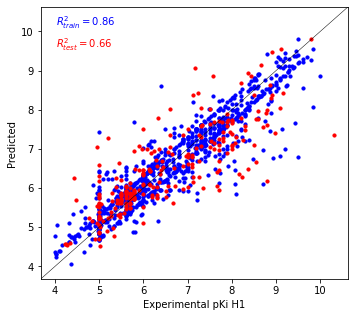

In [11]:
regr = SVR(kernel = "rbf", C=10, epsilon = .3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)


# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel='Experimental pKi H1', savetitle="./data/H1_SVR.png") 

### 1.4 Modeling using Automated Recommendation Tool (ART)

## 2. Binding to muscarinic receptor M2

### 2.1 Data preparation

In [12]:
df = pd.read_csv('./data/data_M2.csv')
df.head()

,compound_id,rdkit_smiles,activity
0,CHEMBL358493,C[N+]12CCC(CC1)C(O)(c1cc3ccccc3o1)C2,5.259637
1,CHEMBL343236,c1ccc2c(c1)CC(C1CN3CCC1CC3)O2,6.309894
2,CHEMBL150845,CC(=C1CCN(C2CCN(C(=O)c3ccc(F)c4ccccc34)CC2)CC1...,8.017729
3,CHEMBL593871,C[C@H]1OC[C@@H](C[N+](C)(C)C)O[C@@H]1C,4.780000
4,CHEMBL91404,CCOC(=O)N1CCC(N2CCC(C(=O)c3ccc(S(=O)(=O)c4ccc5...,9.886057


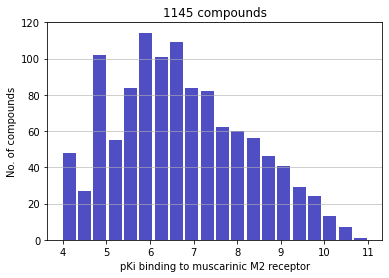

In [13]:
Y = df.activity.to_numpy() # Y are pKi values
smiles = df.rdkit_smiles

plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [14]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size = 0.2, random_state = 42)

### 2.2 Compute Macaw embeddings

In [15]:
#mcw2 = Macaw_optimus(smi_train, y_train, fast=False, verbose=True, Y=y_train)
mcw2 = Macaw(smi_train, edim = 15, Nlndmk = 50, Y = y_train, fptype = "atompairs", metric = "rogot-goldberg")

In [16]:
X_train = mcw2.transform()
X_train.shape

X_test = mcw2.transform(smi_test)
X_test.shape

(229, 15)

### 2.3 Modeling using a SVR

In [17]:
for C in [1,3,5,10,30]:
    regr2 = SVR(kernel = "rbf", C=C, epsilon = .5)
 
    scores = cross_val_score(regr2, X_train, y_train, cv = 5)
    print(scores.mean())

0.6654959706771217
0.6860982584703856
0.6886146516388655
0.6858447947872657
0.668555338972826


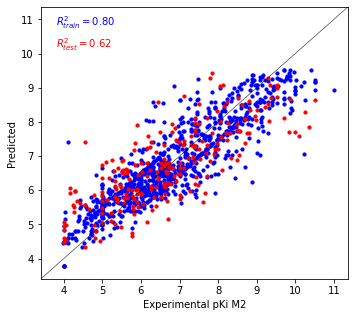

In [18]:
regr2 = SVR(kernel = "rbf", C=3, epsilon = .5)
regr2.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr2.predict(X_train)

# Test set predictions
y_test_pred = regr2.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Experimental pKi M2", savetitle="./data/M2.png")

### 2.4 Modeling using Automated Recommendation Tool (ART)

## 3. Discovery of new hits specific to H1

Here we will screen some libraries looking for promising molecules (i.e. those with high pKi against H1 and low pKi against M2). Ideally, we want the pKi difference to be > 3.

For this, I will use the SVR models `regr` and `regr2`, which use 15-D Macaw embeddings as their input.

In terms of libraries, I will screen some libraries from Enamine.

In [19]:
mylib = pd.read_csv('./data/LibraryVB.csv')
print(mylib.shape)
mylib.head()

(19490, 2)


,Smiles,Source
0,NC(=O)NC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
1,CC(C)CNC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
2,O=C(Cn1cccnc1=O)NC1CCCCCC1,Enamine_antivirals
3,CCC(=O)Nc1ccc(cn1)N1CCOCC1,Enamine_antivirals
4,Cc1nn(C)c(C)c1CC(=O)NC(C1CC1)C1CC1,Enamine_antivirals


In [20]:
smi_lib = mylib.Smiles

In [21]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr.predict(X1_lib)

In [22]:
X2_lib = mcw2.transform(smi_lib)

Y2_lib_pred = regr2.predict(X2_lib)

Let us represent the predictions of both models:

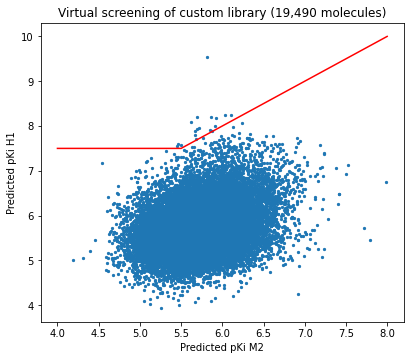

In [23]:
plt.figure(figsize=(6.5,5.5))
plt.scatter(x=Y2_lib_pred,y=Y1_lib_pred,s=5) 
plt.xlabel('Predicted pKi M2')
plt.ylabel('Predicted pKi H1')
plt.title('Virtual screening of custom library (19,490 molecules)')
plt.plot([4,5.5,8],[7.5,7.5,10],c='red')
plt.savefig('./data/H1_library_screening.png')

Let us have a look at the compounds:

In [24]:
indx = np.where((Y1_lib_pred > 7.5)*(Y1_lib_pred > (Y2_lib_pred + 2)))[0]

18


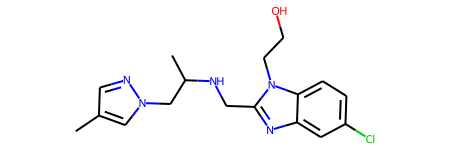

7.952054109879559
5.72268645359615


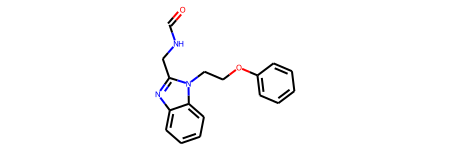

7.797203174376339
5.670115568128713


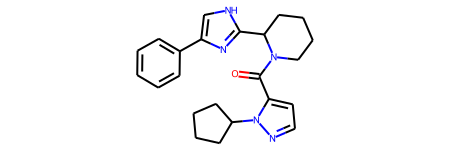

8.20525929549683
5.861870722270027


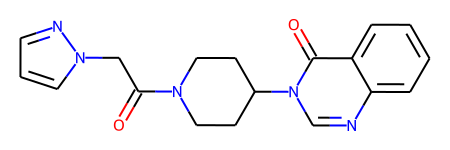

7.893333433444256
5.668570872936273


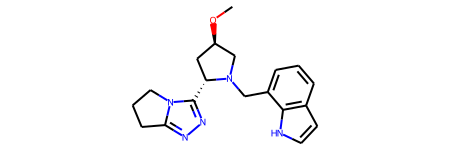

8.17960621115749
5.920251609193459


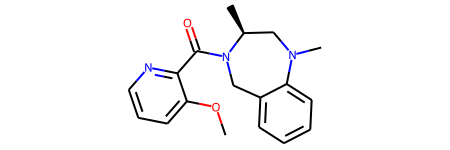

7.557002547588127
5.4450582781819685


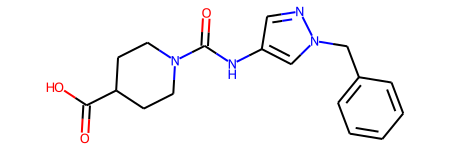

7.999734875600657
5.910049435867355


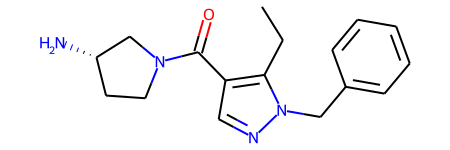

7.580283728083629
5.493082565582398


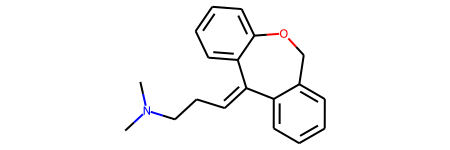

9.543861659386117
5.815854161042099


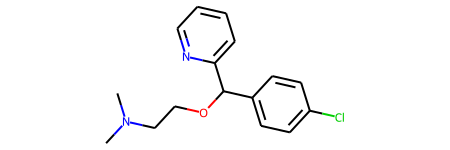

8.243487325793113
6.038156622972393


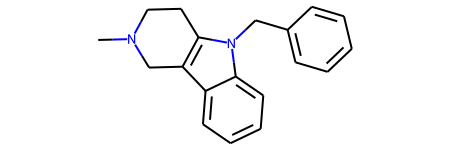

8.079060877042842
5.6179072539051695


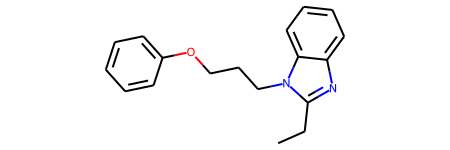

7.8885379752246125
5.879283508538664


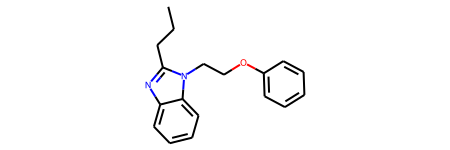

7.90749950887053
5.848938530029439


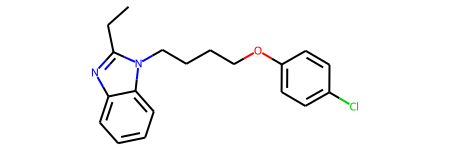

7.923924308171393
5.691091984732583


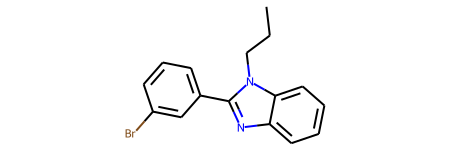

7.605303090077448
5.467535273272239


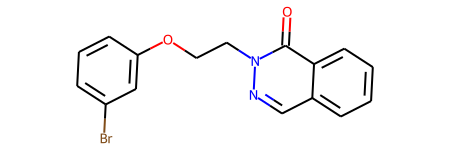

7.707920132099028
5.685428259165126


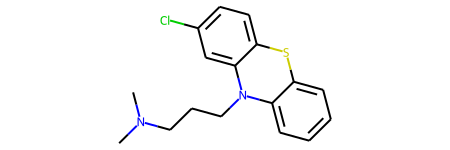

8.23988566869972
6.101913078332014


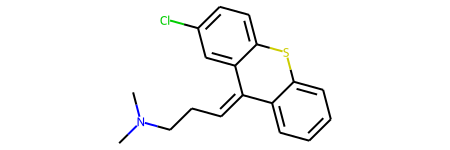

8.210470927011901
5.692694478894


In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(len(indx))

for i in indx:
    MolFromSmiles(smi_lib.iloc[i])
    print(Y1_lib_pred[i])
    print(Y2_lib_pred[i])

In [26]:
lead_df = mylib.iloc[indx].copy()
lead_df['pKi_H1_pred'] = Y1_lib_pred[indx]
lead_df['pKi_M2_pred'] = Y2_lib_pred[indx]

lead_df

,Smiles,Source,pKi_H1_pred,pKi_M2_pred
734,CC(Cn1cc(C)cn1)NCc1nc2cc(Cl)ccc2n1CCO,Enamine_antivirals,7.952054,5.722686
1891,O=CNCc1nc2ccccc2n1CCOc1ccccc1,Enamine_antivirals,7.797203,5.670116
3927,O=C(N1CCCCC1c1nc(c[nH]1)c1ccccc1)c1ccnn1C1CCCC1,Enamine_DDS737,8.205259,5.861871
3958,O=C(Cn1cccn1)N1CCC(CC1)n1cnc2ccccc2c1=O,Enamine_DDS768,7.893333,5.668571
4900,CO[C@@H]1C[C@H](N(Cc2cccc3cc[nH]c23)C1)c1nnc2C...,Enamine_DDS1710,8.179606,5.920252
6394,COc1cccnc1C(=O)N1Cc2ccccc2N(C)C[C@@H]1C,Enamine_DDS3204,7.557003,5.445058
7599,OC(=O)C1CCN(CC1)C(=O)Nc1cnn(Cc2ccccc2)c1,Enamine_DDS4409,7.999735,5.910049
12238,CCc1c(cnn1Cc1ccccc1)C(=O)N1CC[C@H](N)C1,Enamine_DDS9048,7.580284,5.493083
13946,CN(C)CC/C=C\1/c2ccccc2COc2ccccc12,Enamine_Phenotypic,9.543862,5.815854
14508,CN(C)CCOC(c1ccc(Cl)cc1)c1ccccn1,Enamine_Phenotypic,8.243487,6.038157
